In [2]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

import DiabetesModels as Sim
import bayesoptlib as BO

from tqdm import tqdm
from utils import *

import seaborn as sns
sns.set_style('white')


path = 'simulations/calculate_u_opt_CGP/'
all_data = preprocess_simulation_data(path)

Preprocessing data of simulation: 100%|██████████| 1000/1000 [00:04<00:00, 203.02it/s]


In [3]:
u_opt = all_data['u_opt'].squeeze()
# u_opt = u_opt[:,:-1]

u_opt = u_opt * 5

In [4]:
u_opt_mean = np.mean(u_opt,axis=1)
u_opt_upper = np.quantile(u_opt,0.975, axis = 1)
u_opt_lower = np.quantile(u_opt, 0.025, axis = 1)
u_opt_25 = np.quantile(u_opt, 0.25, axis = 1)
u_opt_75 = np.quantile(u_opt, 0.75, axis = 1)

u_max = np.max(u_opt,axis = 1)
u_median = np.median(u_opt, axis = 1)

x = np.linspace(0,20,100) * 5

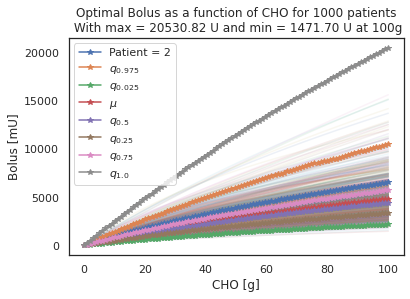

In [5]:
plt.figure()
plt.plot(x, u_opt, '-', alpha = 0.1)
plt.plot(x, u_opt[:,2], '-*', label = 'Patient = 2')
plt.plot(x, u_opt_upper, '-*', label = '$q_{0.975}$')
plt.plot(x, u_opt_lower, '-*', label = '$q_{0.025}$')
plt.plot(x, u_opt_mean,'-*', label = '$\mu$')
plt.plot(x, u_median,'-*', label = '$q_{0.5}$')
plt.plot(x, u_opt_25,'-*', label = '$q_{0.25}$')
plt.plot(x, u_opt_75,'-*', label = '$q_{0.75}$')


plt.plot(x, u_max,'-*', label = '$q_{1.0}$')
plt.xlabel('CHO [g]')
plt.ylabel('Bolus [mU]')
plt.title(f'Optimal Bolus as a function of CHO for {u_opt.shape[1]} patients\n With max = {u_opt.max():.2f} U and min = {u_opt[-1,:].min():.2f} U at 100g')
plt.legend()
plt.savefig('figures/u_opt.pdf', dpi = 150, bbox_inches='tight')
plt.show()

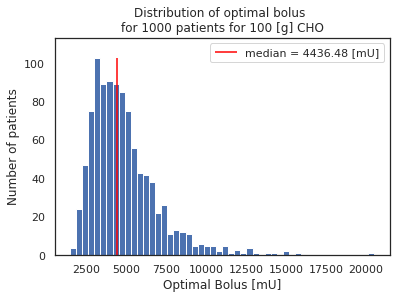

In [9]:
plt.figure()
hist = plt.hist(u_opt[-1,:], bins = 50)[0]
plt.xlabel('Optimal Bolus [mU]')
plt.ylabel('Number of patients')
plt.ylim([0,hist.max()+hist.max()*0.1])
plt.vlines(np.median(u_opt[-1,:]),hist.min(),hist.max(), colors = 'red', label = f'median = {np.median(u_opt[-1,:]):.2f} [mU]' )
plt.title(f'Distribution of optimal bolus \nfor {u_opt.shape[1]} patients for 100 [g] CHO')
plt.legend()
plt.savefig('figures/hist.pdf', dpi = 150, bbox_inches='tight')
plt.show()

In [28]:
import pandas as pd
def idxquantile(s, q=0.5, *args, **kwargs):
    '''
    Finds quantile in given numpy array (asssumin
    '''
    s = pd.Series(u_opt[-1,:])
    qv = s.quantile(q, *args, **kwargs)
    return (s.sort_values()[::-1] <= qv).idxmax()


In [29]:
for q in (0,0.025,0.25,0.5,0.75,0.975,1):
    print(f'q={q}', idxquantile(u_opt,q))

q=0 713
q=0.025 660
q=0.25 622
q=0.5 797
q=0.75 14
q=0.975 535
q=1 346


In [30]:
#### Ordering as a function of patientNr
u_sort = np.argsort(u_opt[-1,:],axis=0)

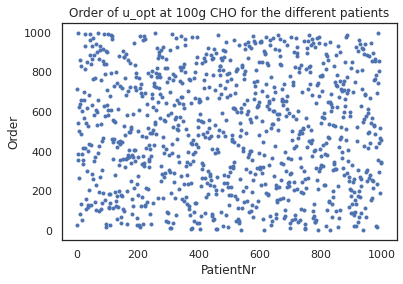

In [32]:
plt.figure()
plt.plot(u_sort.T,'.')
plt.xlabel('PatientNr')
plt.ylabel('Order')
plt.title('Order of u_opt at 100g CHO for the different patients')
plt.savefig('figures/order.pdf', dpi = 150)
plt.show()

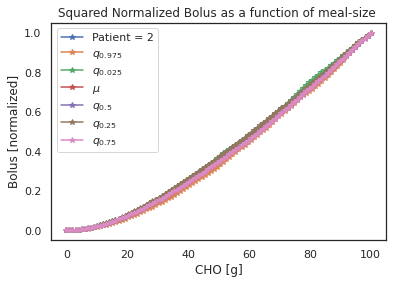

In [41]:
### Example normalization


plt.figure()
# plt.plot(x, u_opt, '-', alpha = 0.1)
plt.plot(x, (u_opt[:,2]/max(u_opt[:,2]))**2, '-*', label = 'Patient = 2')
plt.plot(x, (u_opt_upper/max(u_opt_upper))**2, '-*', label = '$q_{0.975}$')
plt.plot(x, (u_opt_lower/max(u_opt_lower))**2, '-*', label = '$q_{0.025}$')
plt.plot(x, (u_opt_mean/max(u_opt_mean))**2,'-*', label = '$\mu$')
plt.plot(x, (u_median/max(u_median))**2,'-*', label = '$q_{0.5}$')
plt.plot(x, (u_opt_25/max(u_opt_25))**2,'-*', label = '$q_{0.25}$')
plt.plot(x, (u_opt_75/max(u_opt_75))**2,'-*', label = '$q_{0.75}$')


#plt.plot(x, u_max,'-*', label = '$q_{1.0}$')
plt.xlabel('CHO [g]')
plt.ylabel('Bolus [normalized]')
plt.title(f'Squared Normalized Bolus as a function of meal-size ')
plt.legend()
# plt.savefig('figures/u_opt_norm.pdf', dpi = 150, bbox_inches='tight')
plt.show()



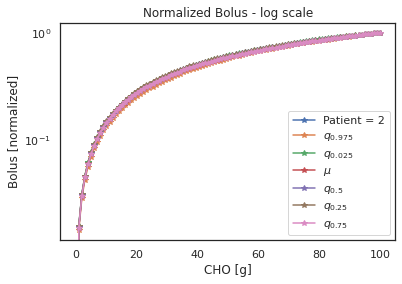

In [36]:
### Example normalization


plt.figure()
# plt.plot(x, u_opt, '-', alpha = 0.1)
plt.semilogy(x, u_opt[:,2]/max(u_opt[:,2]), '-*', label = 'Patient = 2')
plt.semilogy(x, u_opt_upper/max(u_opt_upper), '-*', label = '$q_{0.975}$')
plt.semilogy(x, u_opt_lower/max(u_opt_lower), '-*', label = '$q_{0.025}$')
plt.semilogy(x, u_opt_mean/max(u_opt_mean),'-*', label = '$\mu$')
plt.semilogy(x, u_median/max(u_median),'-*', label = '$q_{0.5}$')
plt.semilogy(x, u_opt_25/max(u_opt_25),'-*', label = '$q_{0.25}$')
plt.semilogy(x, u_opt_75/max(u_opt_75),'-*', label = '$q_{0.75}$')


#plt.plot(x, u_max,'-*', label = '$q_{1.0}$')
plt.xlabel('CHO [g]')
plt.ylabel('Bolus [normalized]')
plt.title(f'Normalized Bolus - log scale')
plt.legend()
plt.savefig('figures/u_opt_norm_log.pdf', dpi = 150, bbox_inches='tight')
plt.show()

